In [364]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import sklearn.preprocessing as Preprocessing
import skimage.io
import skimage.filters
import skimage.color

## Normalize image

In [365]:
def normalize(im):
    im = im - np.amin(im)
    im = im/np.amax(im)
    print(np.amin(im), np.amax(im))
    return im

## Contrast stretching

(300, 400, 3)


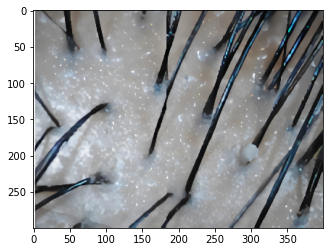

In [366]:
img = cv2.imread('./photos/scalp/image.png')
img = cv2.cvtColor(img, cv2.
                   COLOR_BGR2RGB)
img = cv2.resize(img, (400, 300))
plt.imshow(img)
print(img.shape)

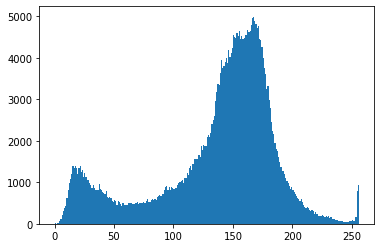

In [367]:
# # alternative way to find histogram of an image
plt.hist(img.ravel(),256,[0,256])
plt.show()

#### Final Function

In [368]:
def contrast_stretch(im, r1, s1, r2, s2):
    '''
    applies a linear transform to stretch the contrast
    im -> normalized image (0 to 1)
    r,s are transit points
    r1 mapped to s1 and r2 mapped to s2
    '''
    im = normalize(im)
    
    m = (s2-s1)/(r2-r1)
    im2 = im-r1
    im2 = im2*m
    im2 = im2 + s1
    
#     normalize
    im2 = normalize(im2)
    im2 = im2 * 255
    im2 = im2.astype('uint8')
    return im2

sun :  {(0.25, 0.1), (0.75, 1)}
dark :  {(0.08, 0.02), (0.75, 0.85)}

In [369]:
cim = contrast_stretch(img, 0.08, 0.02, 0.75, 0.85)
# cim = img.copy()

0.0 1.0
0.0 1.0


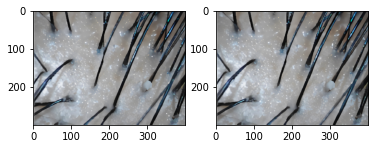

In [370]:
_, axarr = plt.subplots(1,2)

axarr[0].imshow(img)
axarr[1].imshow(cim)

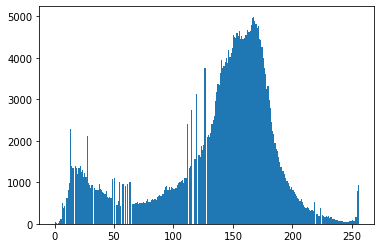

In [371]:
# # alternative way to find histogram of an image
cim_copy = cim
plt.hist(cim_copy.ravel(),256,[0,256])
plt.show()

## Bright spot removal (using mathematical morphology)

In [383]:
def bright_spot_removal(contrast_stretched_im, kernel=np.ones((2,2), np.uint8)):
#     opening = cv2.morphologyEx(contrast_stretched_im, cv2.MORPH_OPEN, kernel)
    contrast_stretched_im_copy = contrast_stretched_im.astype('float32')
    opening = cv2.cvtColor(contrast_stretched_im, cv2.COLOR_RGB2GRAY)
    mask = Preprocessing.binarize(opening, threshold=190)
    #kernel2 = np.ones((2,2), np.uint8)
    opening = cv2.inpaint(contrast_stretched_im, mask.astype('uint8'), 40, cv2.INPAINT_NS)
    return opening

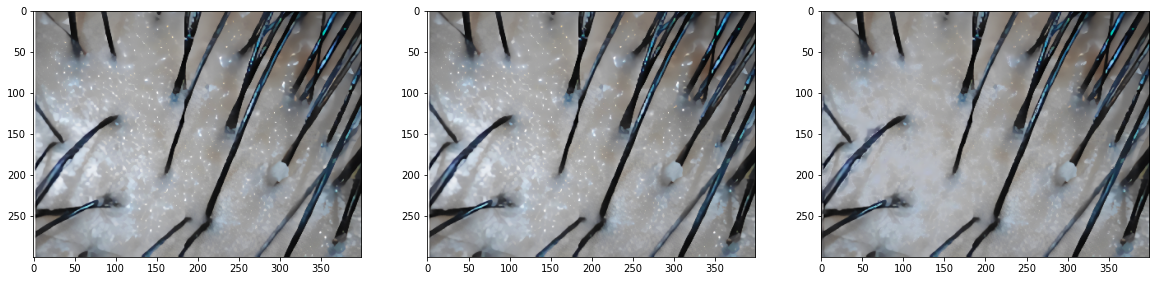

In [384]:
spot_removed = bright_spot_removal(img)
_, axarr = plt.subplots(1,3,figsize=(20,20))

axarr[0].imshow(img)
axarr[1].imshow(cim)
axarr[2].imshow(spot_removed)

## KL transform

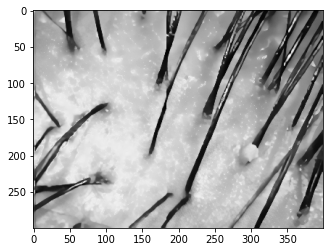

In [385]:
opening = cv2.cvtColor(spot_removed, cv2.COLOR_BGR2GRAY)
plt.imshow(opening, cmap="gray")

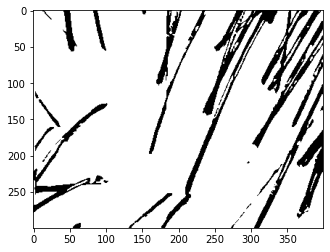

In [386]:
otsu_threshold, binary = cv2.threshold(opening, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU,)
binary = opening.copy()
(x, y) = opening.shape
for i in range(0,x):
    for j in range(0,y):
        if opening[i][j] < otsu_threshold - 30:
            binary[i][j] = 225
        else:
            binary[i][j] = 0
            
plt.imshow(binary, cmap="binary")

## Rescaling

In [387]:
def rescaling(binary_img):
    img_l = cv2.resize(binary_img, (1024, 768))
    img_m = cv2.resize(binary_img, (512, 384))
    img_s = cv2.resize(binary_img, (256, 192))
    
    return(img_l, img_m, img_s)

In [388]:
img_l, img_m, img_s = rescaling(binary)

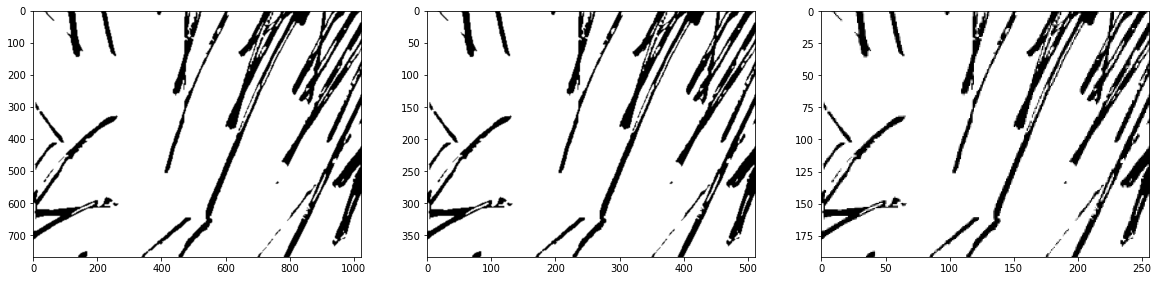

In [389]:
_, axarr = plt.subplots(1,3,figsize=(20,20))

axarr[0].imshow(img_l, cmap="binary")
axarr[1].imshow(img_m, cmap="binary")
axarr[2].imshow(img_s, cmap="binary")

## Canny Edge

In [390]:
from scipy import ndimage as ndi
from skimage.util import random_noise
from skimage import feature

In [391]:
def canny(image):
    #image = ndi.gaussian_filter(image, 4)
    edge = feature.canny(image, sigma=0)
    return edge

In [392]:
edge = canny(binary)

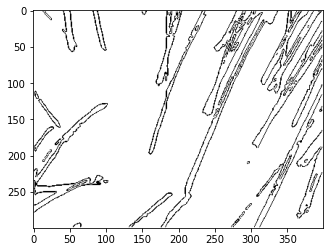

In [393]:
plt.imshow(edge, cmap="binary")

## Thinning

In [394]:
img = np.float32(binary)

In [395]:
def thin(img):
    kernel2 = np.ones((2,2), np.uint8)
    img = cv2.dilate(img, kernel2, iterations=1)
    
    kernel = cv2.getStructuringElement(cv2.MORPH_CROSS,(3,3))
    # Create an empty output image to hold values
    thin = np.zeros(img.shape,dtype='uint8')
    img1 = img
    # Loop until erosion leads to an empty set
    itr = 0
    while (itr<25):
        # Erosion
        itr+=1
        erode = cv2.erode(img1,kernel)
        # Opening on eroded image
        opening = cv2.morphologyEx(erode,cv2.MORPH_OPEN,kernel)
        # Subtract these two
        subset = erode - opening
        # Union of all previous sets
        thin = cv2.bitwise_or(np.float32(subset),np.float32(thin))
        # Set the eroded image for next iteration
        img1 = erode.copy()
    return(thin)

In [396]:
thinn = thin(img)

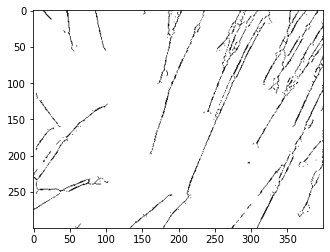

In [397]:
plt.imshow(thinn, cmap="binary")

## Hough LinesP

In [405]:
def HTP(img, thresh, color):
    lines = cv2.HoughLinesP(np.uint8(img), 1, np.pi/180, thresh)
    print(len(lines))
    line_im = np.ones( (img.shape[0], img.shape[1], 3) )
    for x in range(0, len(lines)):
        for x1,y1,x2,y2 in lines[x]:
            cv2.line(line_im,(x1,y1),(x2,y2),(255,0,0),1)
    return line_im

In [406]:
hpt = HT(thinn, 20, 'r')

1596
[[292.           0.40142572]]
[[290.           0.38397244]]
[[407.           0.43633232]]
[[293.           0.43633232]]
[[412.          0.4886922]]
[[411.           0.47123888]]
[[292.          0.4537856]]
[[393.           0.43633232]]
[[216.           0.41887903]]
[[288.           0.36651915]]
[[316.          0.8901179]]
[[359.          0.4886922]]
[[274.           0.34906584]]
[[392.          0.4537856]]
[[401.          0.6632251]]
[[406.           0.47123888]]
[[284.          0.4886922]]
[[358.           0.54105204]]
[[286.           0.47123888]]
[[356.           0.57595867]]
[[214.           0.31415927]]
[[289.          0.4886922]]
[[315.           0.87266463]]
[[291.           0.47123888]]
[[233.         1.012291]]
[[212.           0.29670596]]
[[355.          0.5934119]]
[[409.          0.4537856]]
[[330.           0.43633232]]
[[287.          0.4537856]]
[[287.          0.5061455]]
[[237.          1.0471976]]
[[194.          0.2443461]]
[[235.          1.0297443]]
[[4.03000

[[3.5700000e+02 3.1415927e-01]]
[[4.4100000e+02 3.1415927e-01]]
[[4.0300000e+02 3.3161256e-01]]
[[343.           0.34906584]]
[[3.6100000e+02 3.4906584e-01]]
[[191.           0.36651915]]
[[297.           0.36651915]]
[[337.           0.36651915]]
[[366.           0.36651915]]
[[4.0500000e+02 3.6651915e-01]]
[[352.           0.38397244]]
[[278.           0.41887903]]
[[354.           0.41887903]]
[[186.           0.43633232]]
[[346.           0.43633232]]
[[185.          0.4537856]]
[[456.           0.47123888]]
[[301.          0.4886922]]
[[405.           0.54105204]]
[[262.           0.55850536]]
[[363.           0.55850536]]
[[399.           0.55850536]]
[[407.           0.57595867]]
[[282.           0.61086524]]
[[404.           0.61086524]]
[[136.          0.6457718]]
[[198.          0.6457718]]
[[247.          0.6632251]]
[[121.          0.6806784]]
[[334.         0.715585]]
[[398.          0.7330383]]
[[325.          0.7679449]]
[[411.          0.7679449]]
[[243.          0.7853

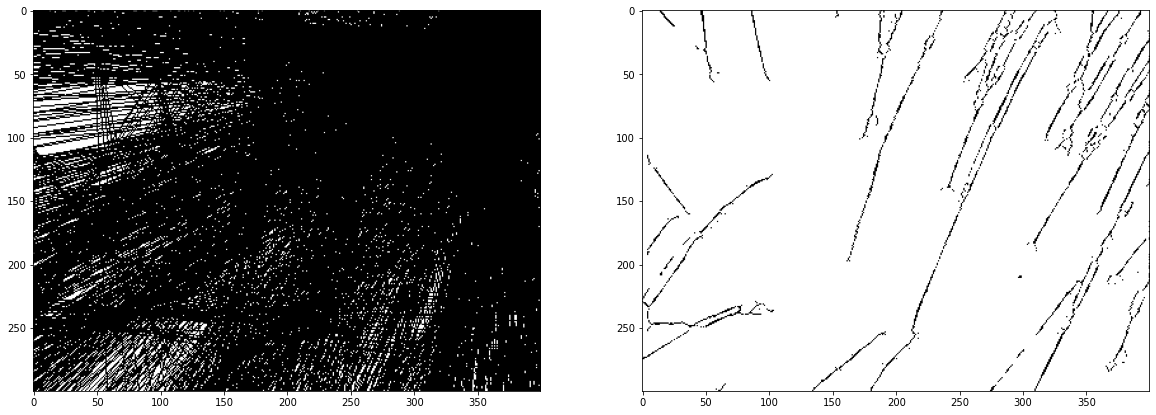

In [407]:
_, axarr = plt.subplots(1,2,figsize=(20,20))
axarr[0].imshow(hpt)
axarr[1].imshow(thinn, cmap="binary")

In [408]:
tl = thin(img_l)
hl = HTP(tl, 20, 'r')

tm = thin(img_m)
hm = HTP(tm, 20, 'g')

ts = thin(img_s)
hs = HTP(ts, 20, 'b')

h1 = cv2.resize(hl, (1024, 768))
h2 = cv2.resize(hm, (1024, 768))
h3 = cv2.resize(hs, (1024, 768))

tl = cv2.resize(tl, (1024, 768))
tm = cv2.resize(tm, (1024, 768))
ts = cv2.resize(ts, (1024, 768))

8396
1797
408


In [409]:
hf = (h1 + h2 + h3)/3

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


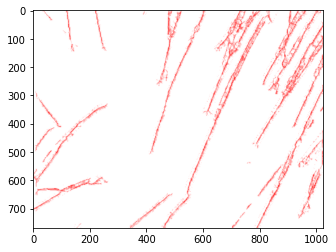

In [410]:
plt.imshow(hf)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


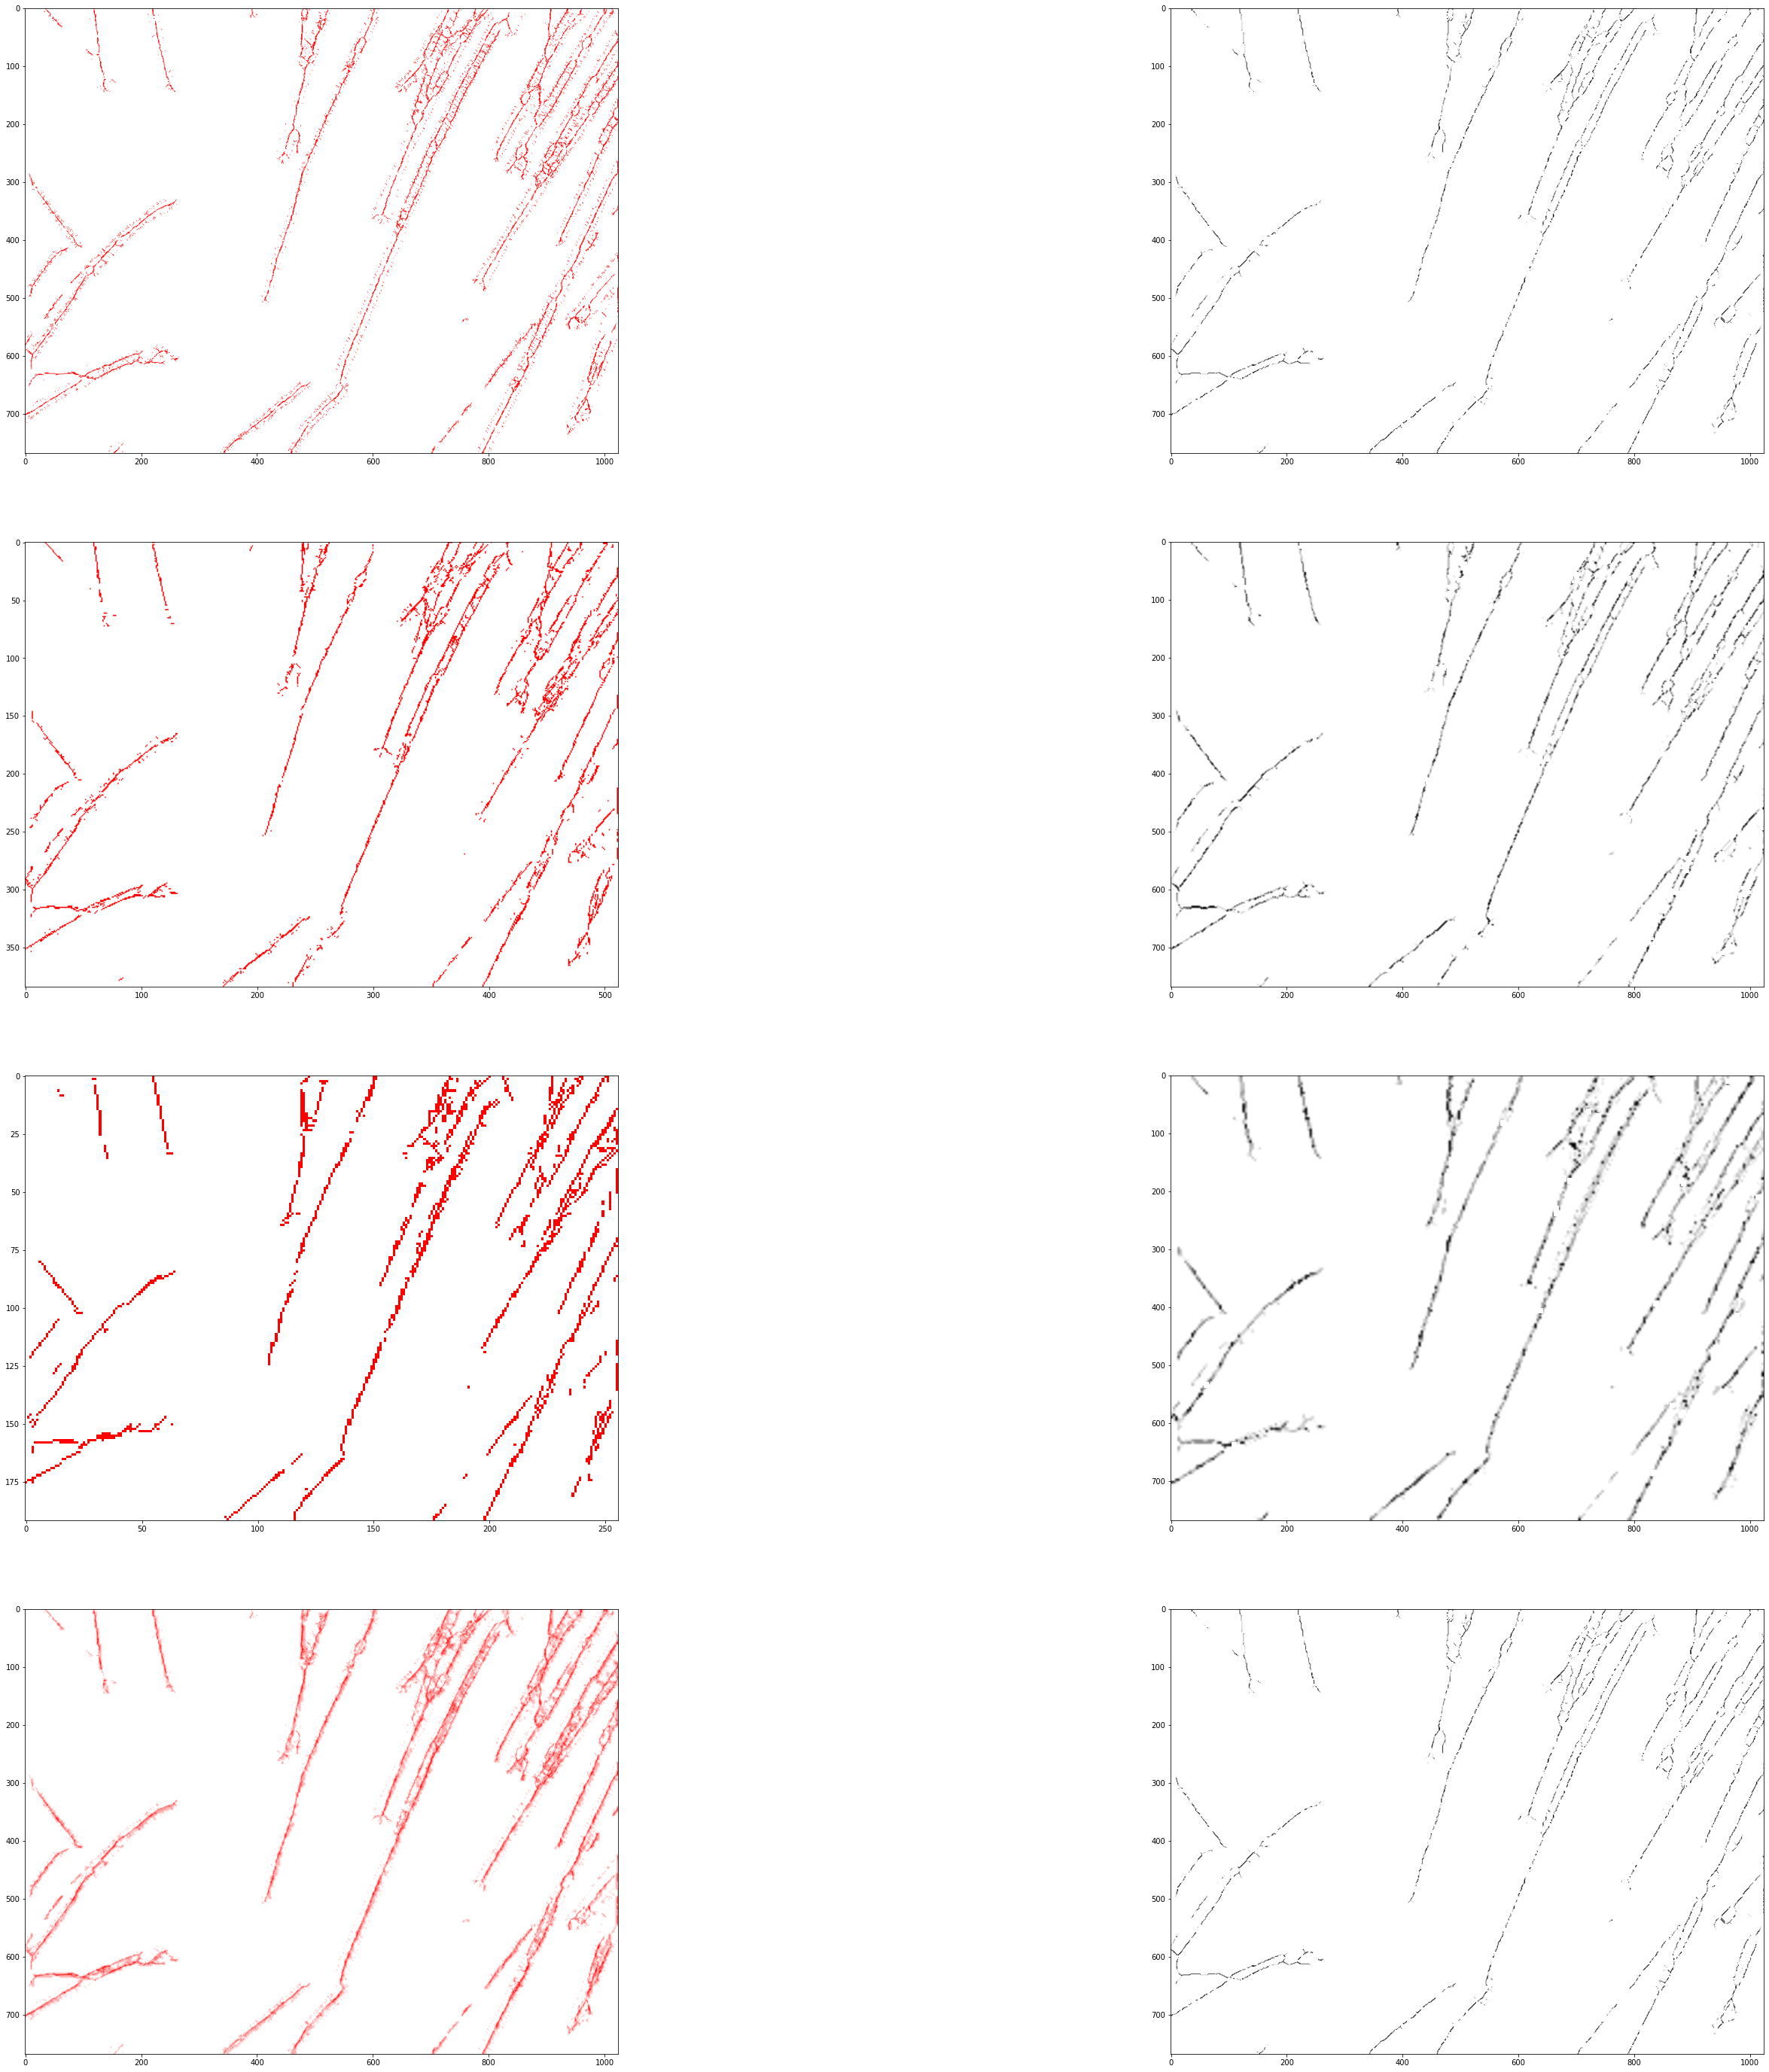

In [411]:
_, axarr = plt.subplots(4,2,figsize=(50,50))

axarr[0][0].imshow(h1)
axarr[0][1].imshow(tl, cmap="binary")
axarr[1][0].imshow(hm)
axarr[1][1].imshow(tm, cmap="binary")
axarr[2][0].imshow(hs)
axarr[2][1].imshow(ts, cmap="binary")
axarr[3][0].imshow(hf)
axarr[3][1].imshow(tl, cmap="binary")


#### Parallel Line Bundling

In [ ]:
plt.imshow(edge, cmap="binary")

In [ ]:
# HTP
def PLB(img, thresh):
    ms = []
    lines = cv2.HoughLinesP(np.uint8(img), 1, np.pi/180, thresh)
    print(len(lines))
    line_im = np.ones( (img.shape[0], img.shape[1], 3) )
    for x in range(0, len(lines)):
        for x1,y1,x2,y2 in lines[x]:
            cv2.line(line_im,(x1,y1),(x2,y2),(255,0,0),3)
            m = (y2-y1)/((x2-x1)+0.00000001)
            ms.append(m)
    return line_im, ms

In [ ]:
ht, ms = PLB(edge, 50)

In [ ]:
plt.imshow(ht)

In [ ]:
ms

## rescaling

In [ ]:
def rescale_pre(img):
    img = np.uint8(img)
    
    img1 = cv2.resize(img, (1024, 768))
    img2 = cv2.resize(img, (512, 384))
    img3 = cv2.resize(img, (256, 192))
    
    ht1 = HT(img1, 0)
    ht2 = HT(img2, 0)
    ht3 = HT(img3, 0)
    
    ht2 = cv2.resize(ht2, (1024, 768))
    ht3 = cv2.resize(ht3, (1024, 768))
    
    ht = ht1 + ht2 + ht3
    return ht

In [ ]:
ht = rescale_pre(thinn)

In [ ]:
img3 = cv2.resize(np.uint8(thinn), (256, 192))

In [ ]:
plt.imshow(img2, cmap="binary")

In [ ]:
ht2 = HT(img3, 0)

In [ ]:
plt.imshow(ht, cmap="binary")